## Plot time seres from a specifed location using the yeoda modole to query the EODC S1 datacube

In [1]:
import os, osr, glob
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import pandas as pd
# import TUW packages
from yeoda.products.preprocessed import SIG0DataCube
from geopathfinder.naming_conventions.yeoda_naming import YeodaFilename

Specify the folder with a S1 datacube (a 300x300 m<sup>2</sup> Equi7Tile)

In [2]:
#tile_dirpath = r'/project/return/Share/EODC_SA020M/V01R01/E051N060T3'
tile_dirpath = r'/project/return/Share/EODC_SA020M/V01R01/E078N066T3'
# specify other parameters:
dimensions=['time', 'band', 'extra_field', 'sensor_field']
filepaths = glob.glob(os.path.join(tile_dirpath,'*.tif'))

Read the datacube:

In [3]:
sig0_dc = SIG0DataCube(filepaths=filepaths, dimensions=dimensions, filename_class=YeodaFilename, sres=20, continent='SA')
# get info:
sig0_dc.inventory[dimensions].head(5)

,time,band,extra_field,sensor_field,var_name,tile_name
0,2019-09-24 09:22:59,VH,D039,S1AIWGRDH,SIG0,E078N066T3
1,2020-11-18 09:14:33,VH,D141,S1B,SIG0,E078N066T3
2,2020-06-21 09:15:13,VV,D141,S1A,SIG0,E078N066T3
3,2019-02-03 09:14:37,VV,D141,S1AIWGRDH,SIG0,E078N066T3
4,2019-02-08 09:23:15,VH,D039,S1AIWGRDH,SIG0,E078N066T3


Filter by date:

In [ ]:
toi_start, toi_end = datetime(2020, 1, 1), datetime(2021, 1, 1)
sig0_dc.filter_by_dimension([(toi_start, toi_end)], [(">", "<")], name="time", inplace=True)

Select bands:

In [4]:
sig0_vv_dc = sig0_dc.filter_by_dimension('VV', name='band')
sig0_vh_dc = sig0_dc.filter_by_dimension('VH', name='band')

Get a time series for a point of interest:

In [5]:
#poi = (-8.345586, -78.70486)
poi = (-2.70919, -54.95610)
sref = osr.SpatialReference()
sref.ImportFromEPSG(4326)
sig0_vv_ts = sig0_vv_dc.load_by_coords(*poi, sref=sref, dtype='numpy')
sig0_vh_ts = sig0_vh_dc.load_by_coords(*poi, sref=sref, dtype='numpy')

make a pandas series object:

In [6]:
# note taht the datacube bacscatter values have to be divided by 100 to get the backscatter in dB-s 
poi_ts_vh = pd.Series(sig0_vh_ts[:, 0, 0]/100, index=sig0_vh_dc['time'])
poi_ts_vh.dropna(inplace=True)
poi_ts_vh.head(5)

time
2019-09-24 09:22:59   -1.396
2020-08-25 09:23:05   -1.448
2020-05-09 09:22:58   -1.435
2020-06-14 09:23:00   -1.313
2019-04-09 09:22:50   -1.240
dtype: float64

In [19]:
poi_ts_vv = pd.Series(sig0_vv_ts[:, 0, 0]/100, index=sig0_vv_dc['time'])
poi_ts_vv.dropna(inplace=True)
poi_ts_vv.head(5)

time
2020-05-21 09:22:59   -0.656
2019-12-17 09:22:58   -0.657
2020-08-25 09:23:05   -0.927
2020-09-30 09:23:06   -0.841
2019-11-23 09:22:59   -0.828
dtype: float64

Plot a timeseries:

<AxesSubplot:xlabel='Time', ylabel='Bacscatter Intensity [dB]'>

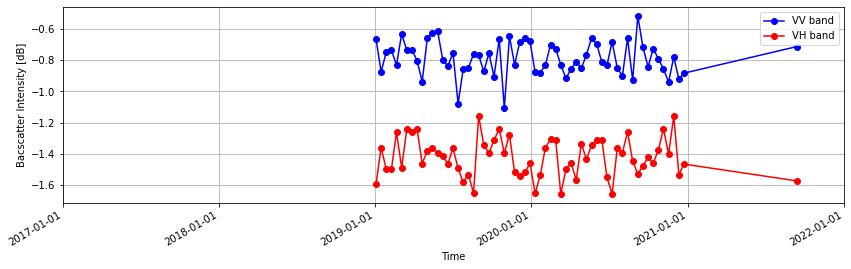

In [21]:
# create xticks
my_xticks = pd.date_range(datetime(2017,1,1), datetime(2022,1,1), freq='YS')
poi_ts_vv.plot(style='bo-', xticks=my_xticks,  grid=True, figsize=(14,4), label='VV band', legend=True, xlabel='Time', ylabel='Bacscatter Intensity [dB]')
poi_ts_vh.plot(style='ro-', xticks=my_xticks,  grid=True, figsize=(14,4), label='VH band', legend=True, xlabel='Time', ylabel='Bacscatter Intensity [dB]')